### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [17]:
import sys  
sys.path.insert(0, '../')

import HPO
import pysgpp
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import sklearn.metrics
from sklearn.model_selection import KFold
import numpy as np
import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from numpy.random import seed
import random
import time
import os
import math
from matplotlib import cm
import matplotlib 

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

random.seed(1)
seed(2)
tf.random.set_seed(3)

def reset_seeds():
    np.random.seed(1)
    random.seed(2)
    tf.random.set_seed(3)

VERBOSE = 0

SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

### Hyperparameter space definition

In [18]:
hyperparameterspace = {
    'x0': ["interval", -5, 10],
    'x1': ["interval", -5, 10],
    #'learning_rate': ["interval-log", 0.000000001, 0.1],
    #'number_layers': ["interval-int", 1, 20],
    #'neurons_per_layer': ["interval-int", 1, 50]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste



### Experiment parameters

In [19]:


BUDGETS = [1 + i * 52 for i in range(19)]

### Optimization

Current adaptivity: 0.0
Optimum:
[1.2940465784914394, 1.6545223520666146]
0.12660028820910413


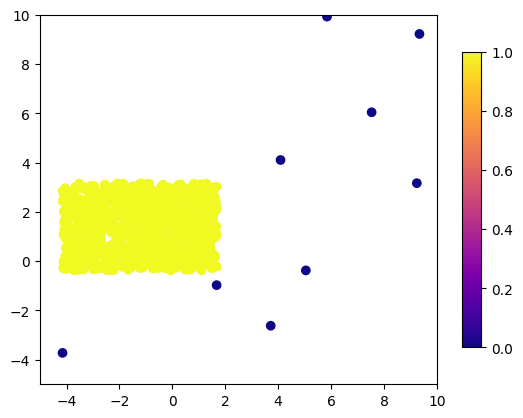

Current adaptivity: 0.1
Optimum:
[1.2940465784914394, 1.6545223520666146]
0.12660028820910413


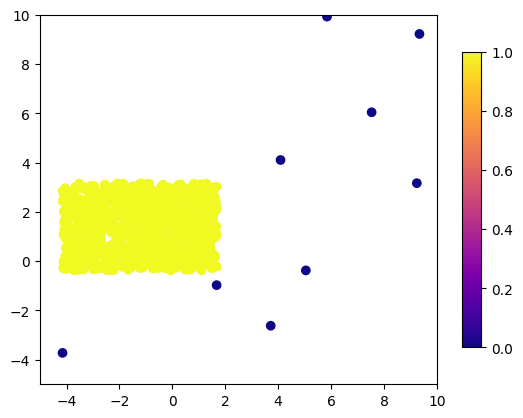

Current adaptivity: 0.2
Optimum:
[1.2940465784914394, 1.6545223520666146]
0.12660028820910413


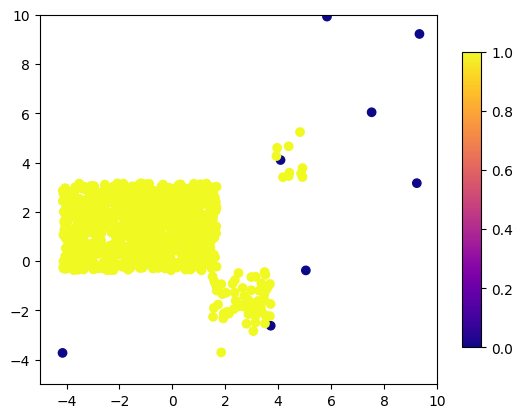

Current adaptivity: 0.30000000000000004
Optimum:
[1.2940465784914394, 1.6545223520666146]
0.12660028820910413


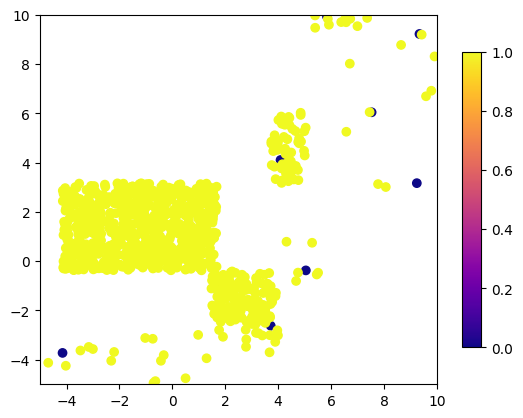

Current adaptivity: 0.4
Optimum:
[0.8983167695209202, 0.8483669830100922]
0.18168550995410335


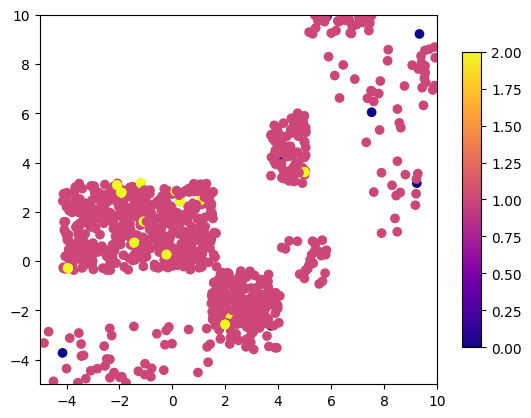

Current adaptivity: 0.5
Optimum:
[1.2940465784914394, 1.6545223520666146]
0.12660028820910413


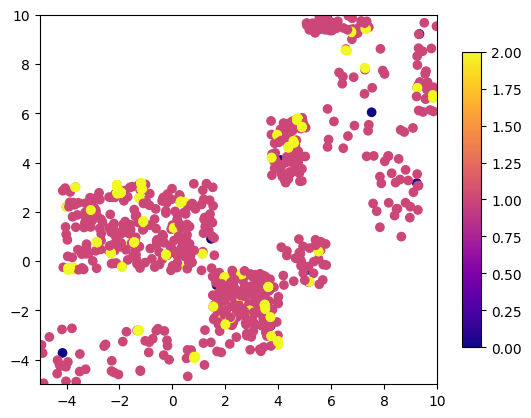

Current adaptivity: 0.6000000000000001
Optimum:
[1.6083357398304123, 2.59896018228899]
0.38499624488928363


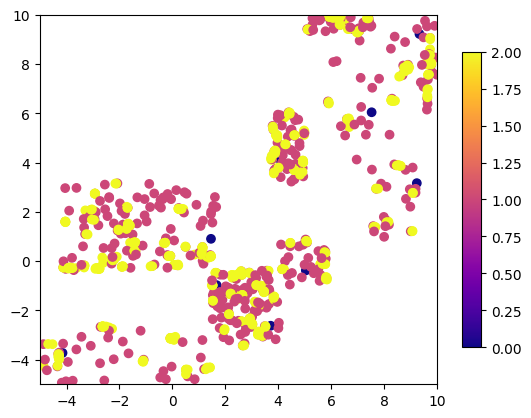

Current adaptivity: 0.7000000000000001
Optimum:
[1.4487362611803571, 2.1305461134180765]
0.3019125766586986


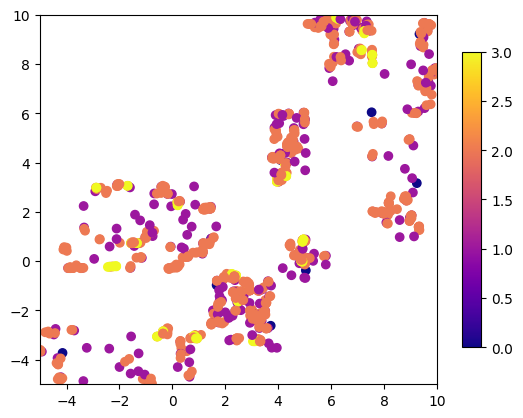

Current adaptivity: 0.8
Optimum:
[-0.36535476338955153, 0.06957672965002276]
2.272608868439812


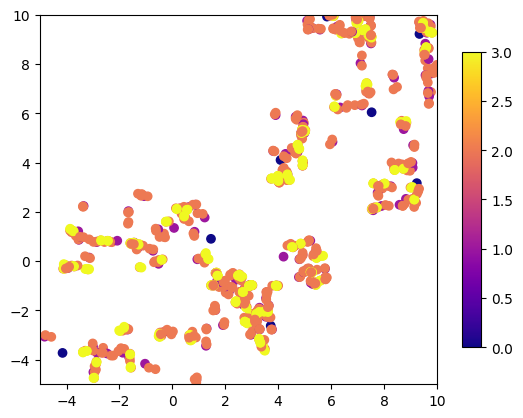

Current adaptivity: 0.9
Optimum:
[-0.7323535542045264, 0.5926065540633003]
3.3176218979523187


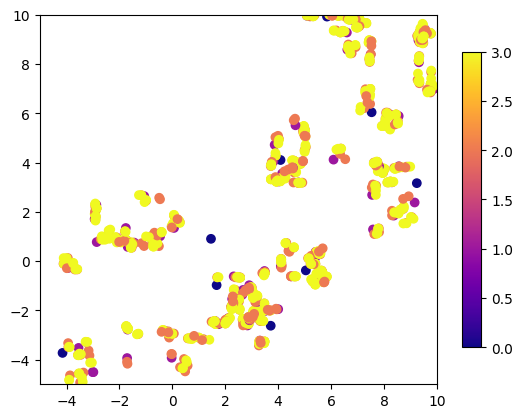

Current adaptivity: 1.0
Optimum:
[-0.7641375525645487, 0.7232647804444677]
5.0542627199190955


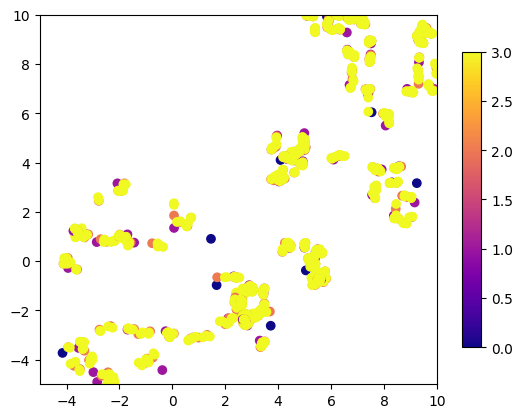

In [20]:

################## MODEL AND FUNCTION DEFINITION ####################

def evaluate_model(epochs, batch_size):
    #return epochs * batch_size
    ################### ROSENBROCK ###############
    sum = 0
    sum += (1-epochs)**2 + 100 * (batch_size - epochs**2) ** 2
    return sum

    # ################# RASTRIGIN #################
    sum = 0
    sum += epochs ** 2 - 10 * math.cos(2 * math.pi * epochs)
    sum += batch_size ** 2 - 10 * math.cos(2 * math.pi * batch_size)
    
    return len(hyperparameterspace) * 10 + sum

def function(coordinates):
    return evaluate_model(coordinates[0], coordinates[1])


for i in range(11):
    reset_seeds()

    print("Current adaptivity:", i*0.1)

    optimizer = HPO.IterativeRandomOptimization(HPO.Dataset([],[]), function, hyperparameterspace, 1000, 0, i*0.1, init_points=10, alternative=0)
    points = optimizer.fit()

    smallest_value = points[0].get_value()
    index = 0
    for j in range(len(points)):
        if points[j].get_value() < smallest_value:
            smallest_value = points[j].get_value()
            index = j

    print("Optimum:")
    print(points[index].get_coordinates())
    print(points[index].get_value())


    x_values = []
    y_values = []
    z_values = []

    for i in range(len(points)):
        x_values.append(points[i].get_coordinates()[0])
        y_values.append(points[i].get_coordinates()[1])
        z_values.append(points[i].get_level())

    
    # cmap = plt.cm.jet  # define the colormap
    # # extract all colors from the .jet map
    # cmaplist = [cmap(i) for i in range(cmap.N)]
    # cmap = mpl.colors.LinearSegmentedColormap.from_list(
    #     'Custom cmap', cmaplist, cmap.N)

    # # define the bins and normalize
    # bounds = np.linspace(min(z_values), max(z_values), max(z_values)+1)
    # norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    fig = plt.figure()
    ax = plt.axes()
    surface = plt.scatter(x_values, y_values, c=z_values, cmap="plasma")

    ax.set_xlim([-5, 10])
    ax.set_ylim([-5, 10])

    fig.colorbar(surface, shrink=0.8, aspect=15)


    plt.show()
